In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
from mpl_toolkits.mplot3d import Axes3D

In [2]:
matplotlib inline

# Solution 0: play with values (a, u) until you hit the star

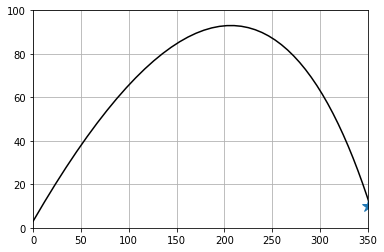

In [3]:
g = 32; r = 1/5;

# Answers for x(t) and y(t)  (assuming X(0)=0, Y(0)=0)
X = lambda T,a,u:  u/r * np.cos(a) * (1-np.exp(-r*T))
Y = lambda T,a,u:  -g/r*T + (g/(r**2) + u/r * np.sin(a)) * (1-np.exp(-r*T))

plt.figure(); plt.axis([0,350,0,100]); plt.grid()
# Star marks the target
plt.plot(350, 10, '*', markersize=12)

# Try to guess u and a
u = 146;  a = 0.65
tt = np.linspace(0,5)
plt.plot(X(tt, a, u), 3 + Y(tt, a, u),'k-')

# Solution 1: Numerical Constrained Optimization

In [4]:
# Define constraint (1): distance 350 or greater
def Eq1(vars):
    T = vars[0]; a = vars[1]; u = vars[2];
    g = 32; r = 1/5;
    return u/r * np.cos(a) * (1-np.exp(-r*T))
Eq1c = scipy.optimize.NonlinearConstraint(Eq1, 350, np.inf)

# Define constrant (2): height 10 or greater
def Eq2(vars):
    T = vars[0]; a = vars[1]; u = vars[2];
    g = 32; r = 1/5; h = 3
    return h - g/r*T + (g/(r**2) + u/r * np.sin(a)) * (1-np.exp(-r*T))
Eq2c = scipy.optimize.NonlinearConstraint(Eq2, 10, np.inf)

# Define function to minimize: u (which is vars[2])
def F(vars):
    return vars[2]

# Run the optimization routine
res = scipy.optimize.minimize(F, [5, np.pi/4, 200], 
                              method='trust-constr', constraints=[Eq1c, Eq2c])
print(res.x)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


[  4.60835943   0.64372082 145.3373851 ]


# Solution 2: Lagrange multipliers gives a third condition

In [5]:
# Define the system of 3 variable with 3 unknowns
def Lagrange(vars):
    T = vars[0]; a = vars[1]; u = vars[2];
    g = 32; r = 1/5;
    return [u/r * np.cos(a) * (1-np.exp(-r*T)) - 350,
        -g/r*T + (g/(r**2) + u/r * np.sin(a)) * (1-np.exp(-r*T)) - 7,
        u*np.exp(-r*T) - g/r * np.sin(a)*(1-np.exp(-r*T))]

# Run the root-finding routine
res = scipy.optimize.root(Lagrange, [5, np.pi/4, 200])
print(res.x)

[  4.60835781   0.64372052 145.33738146]


# Solution 3: eliminate A, get u as a function of t, minimize

145.33738146413748 0.643720523792802


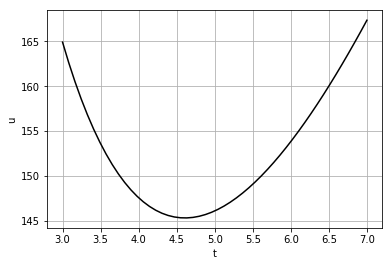

In [6]:
# Eliminate A from the constraints: get a single constraint in the form u = F(t)
def F(T):
    r=1/5; g=32; h=3
    Xtarget = 350; Ytarget = 10
    return r*np.sqrt( (Xtarget/(1-np.exp(-r*T)))**2 
                     + ( (Ytarget-h+g/r*T)/(1-np.exp(-r*T)) - g/r**2 )**2 )

# Plot F as a function of t
tt = np.linspace(3,7)
plt.figure()
plt.plot(tt, F(tt), 'k-')
plt.grid(); plt.xlabel('t'); plt.ylabel('u');

# Run unconstrained optimization
minF = scipy.optimize.minimize_scalar(F, bounds=(3,7), method='bounded')
bestU = minF.fun
r=1/5;
bestA = np.arccos(350*r / (bestU*(1-np.exp(-r*minF.x))))
print(bestU, bestA)

# Solution 4: eliminate t get single constraint

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


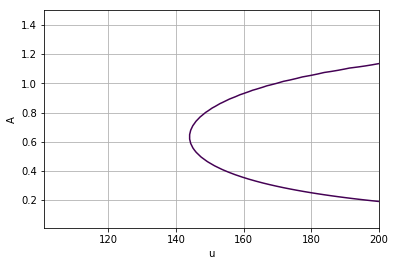

In [7]:
# Constraint after t is eliminated
def Eqn(u, a):
    g=32; r=1/5;
    return g/r/r*np.log(1-350*r/u/np.cos(a)) + 350*(u*np.sin(a)+g/r)/u/np.cos(a)

# Plot the constraint itself (it's a curve in 2 dimensions)
uu, aa = np.meshgrid(np.linspace(101,200), np.linspace(0.01, 1.5))
fig = plt.figure()
plt.grid()
plt.contour(uu,aa, Eqn(uu,aa), [0])
plt.xlabel('u'); plt.ylabel('A');